# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [19]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [20]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [21]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [22]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        print(f"Choosing action: {('stick', 'hit')[action]}")
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)') if reward > 0 else print('You lost :(')
            # This line only works in my custom modifcation of the gym's blackjack.py file
            print(f"Done reason: {info['done_reason']}")
            print(f"Dealer cards: {info['dealer_hand']}; sum: {sum(info['dealer_hand'])}")
            print()
            break

(17, 5, False)
Choosing action: stick
End game! Reward:  -1.0
You lost :(
Done reason: stick
Dealer cards: [5, 3, 10]; sum: 18

(17, 7, False)
Choosing action: hit
End game! Reward:  -1.0
You lost :(
Done reason: bust
Dealer cards: [7, 8]; sum: 15

(8, 8, False)
Choosing action: hit
(19, 8, True)
Choosing action: stick
End game! Reward:  -1.0
You lost :(
Done reason: stick
Dealer cards: [8, 8, 4]; sum: 20



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [23]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [24]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((20, 5, False), 0, 1.0)]
[((8, 4, False), 1, 0.0), ((13, 4, False), 1, 0.0), ((16, 4, False), 0, 1.0)]
[((13, 9, True), 0, -1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

### Pseudocode of implementation

<img src="images/First-Visit-MC-pseudocode.png" alt="Pseudocode of implementation" width="500"/>

In [25]:
def compute_returns(episode, gamma):
    """Computes the discounted return at every step of an episode. 
    This is a generic implementation. It could be simplified for blackjack, since all
    rewards are 0 except for the last one."""
    
    returns = []
    for step in reversed(episode):  # Reverse because the returns are computed accumulating
                                    # discounted rewards starting from of the last state
        state, action, reward = step
        if len(returns) == 0:
            _return = reward
        else:
            _return = reward + gamma * returns[0]
        returns.insert(0, _return)
    return returns

In [26]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    """The generate_episode function contains the implementation of the policy"""
    
    # initialize empty dictionaries of arrays
    # Note: Since there are 2 possible actions, env.action_space.n == 2 and
    # np.zeros(env.action_space.n)) == [ 0.  0.]
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        episode = generate_episode(env)
        
        returns = compute_returns(episode, gamma)
        
        visited_states = set()  # For generic implementation on first-visit. This is not 
                                # really needed for BlackJack since in this game the same
                                # state can't happen more than once per episode

        for step, _return in zip(episode, returns):
            state, action, reward = step
            if state not in visited_states:
                visited_states.add(state)
                N[state][action] += 1
                returns_sum[state][action] += _return
            
    for state in N:
        for action in range(env.action_space.n):
            Q[state][action] = returns_sum[state][action] / N[state][action]
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

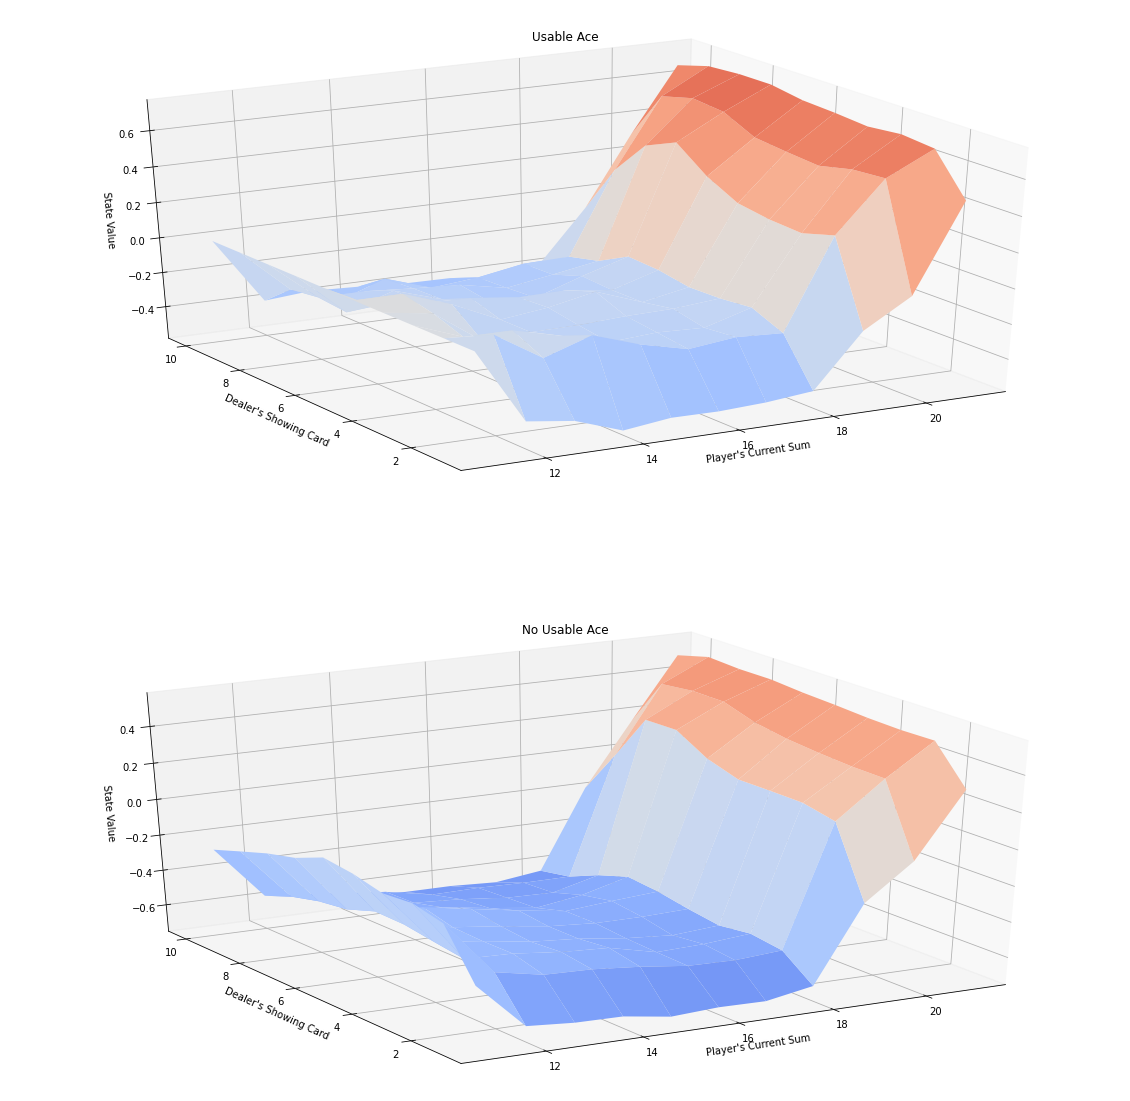

In [27]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

### Pseudocode of implementation

<img src="images/First-Visit-MC-constant-alpha-pseudocode.png" alt="Pseudocode of implementation" width="500"/>

In [28]:
def get_greedy_policy(Q, nA):
    """This computes the greedy policy"""
    policy = {}
    for state in Q:
        policy[state] = np.argmax(Q[state])
    return policy

In [29]:
def get_epsilon_greedy_action(state, Q, epsilon=0.01):
    """This chooses an action using the epsilon-greedy policy"""
    if state not in Q or np.random.random() < epsilon:
        action = np.random.choice(np.arange(2))  # Random action
    else:
        action = np.argmax(Q[state])  # Same as the greedy policy above
    return action

In [30]:
def generate_episode_from_limit_e_greedy(bj_env, Q, epsilon):
    episode = []
    state = bj_env.reset()
    done = False
    while not done:
        action = get_epsilon_greedy_action(state, Q, epsilon)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state

    return episode

In [31]:
def mc_control(env, initial_Q=None, num_episodes=100000, alpha=0.05, gamma=1.0, 
               eps_start=1.0, eps_decay=.9995, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = initial_Q if initial_Q is not None else defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\b\b\b\b\b\b\rEpisode {}/{}. epsilon={}".format(
                i_episode, num_episodes, round(epsilon, 6)), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        episode = generate_episode_from_limit_e_greedy(env, Q, epsilon)
        epsilon = max(eps_decay * epsilon, eps_min)
        
        returns = compute_returns(episode, gamma)
        
        visited_states = set()  # For generic implementation on first-visit. This is not 
                                # really needed for BlackJack since in this game the same
                                # state can't happen more than once per episode

        for step, _return in zip(episode, returns):
            state, action, reward = step
            if state not in visited_states:
                visited_states.add(state)
                Q[state][action] += alpha * (_return - Q[state][action])
        
    policy = get_greedy_policy(Q, nA)
    
    print(f"\nLast value of epsilon={epsilon}")
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [32]:
# Help to find eps_decay
def get_eps_decay(num_episodes=1000000, eps_min=0.001):
    # If we want to train 1/3 of the time with eps_min, then:
    # eps_min = eps_decay ** (num_episodes * 2 / 3)
    eps_decay = eps_min ** (1/(num_episodes * 2 / 3))
    print(f"Best eps_decay = {eps_decay}")
get_eps_decay(num_episodes=1000000, eps_min=0.0001)

Best eps_decay = 0.9999861845848758


In [33]:
# obtain the estimated optimal policy and action-value function
#policy, Q = mc_control(env, ?, ?)
#policy, Q = mc_control(env, 10000000, alpha=0.001, gamma=1.0, eps_start=1.0, eps_decay=.9999992, eps_min=0.001)

# This produces almost the optimal policy...
#policy, Q = mc_control(env, 1000000000, alpha=0.0005)

# Trying to improve the almost-optimal polidy with the following led to a worse policy
policy, Q = mc_control(env, initial_Q=Q, num_episodes=1000000, alpha=0.0001, 
                       gamma=1.0, eps_start=1.0, eps_decay=.9999861845, eps_min=0.0001)

Episode 1000000/1000000. epsilon=0.0001
Last value of epsilon=0.0001


Next, we plot the corresponding state-value function.

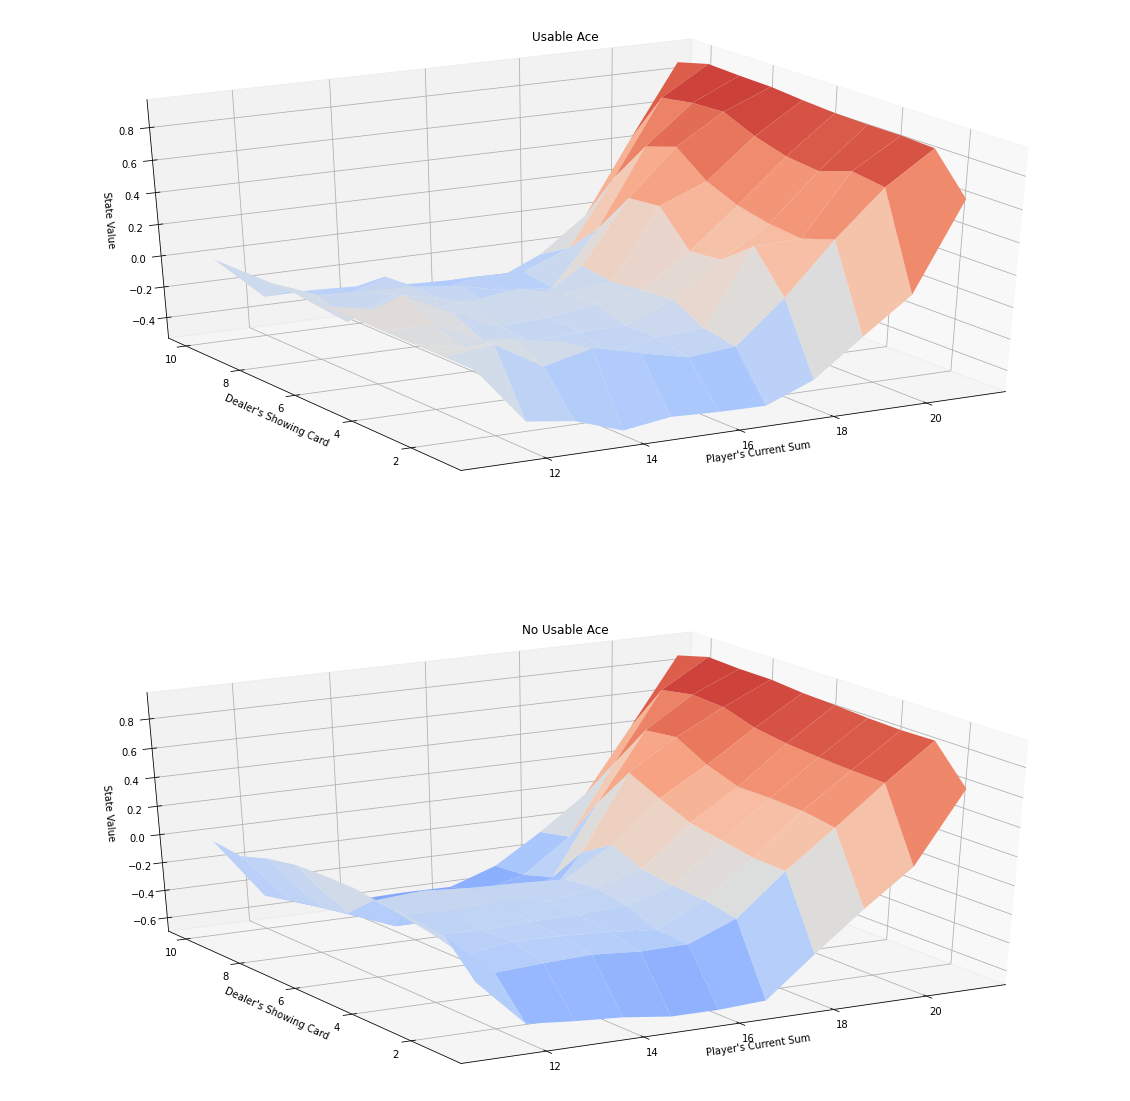

In [34]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

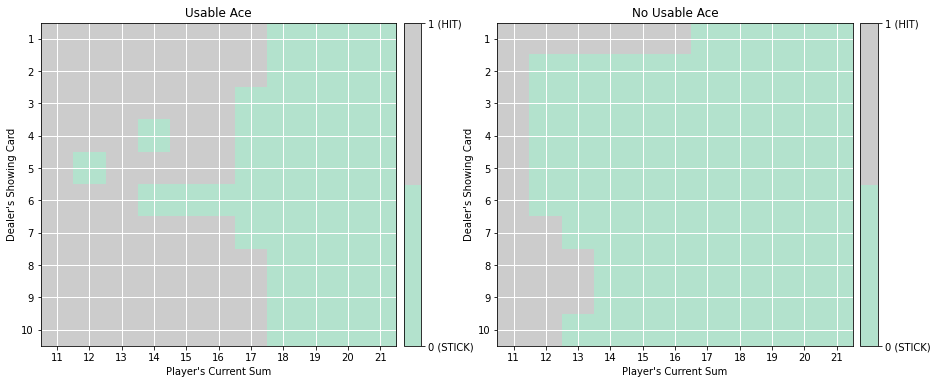

In [35]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)